# Recurrentization benchmarks

This notebooks contains codes to play with recurrentization.

The following results are reproduced:
1. Figure 5: Layer-wise memory footprint profiling.
2. Figure 11 (b): Analytical computation overhead (FLOPS) comparison among the original model,
   the patch-to-patch inference model, and the recurrentized model.


## imports and global utils

In [2]:
%matplotlib inline

from pathlib import Path
import sys
import json

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

script_dir = Path.cwd()
project_folder = script_dir.parent
if str(project_folder) not in sys.path:
    sys.path.insert(0, str(project_folder))

from src.models.config import ExperimentConfig
from src.models.data import single_dataset_factory
from src.models.networks import unet_factory
from src.optimization import recurrentization, utils

2025-03-17 10:46:45.246167: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 10:46:45.267643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 10:46:45.267662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 10:46:45.268491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 10:46:45.272549: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# for visualization
colors_dict = {
    "golden_gate_bridge": "#F24C00",
    "pumpkin": "#FC7A1E",
    "sunset": "#F9C784",
    "platinum": "#e7e7e7",
    "periwinkle": "#AEB8FE",
    "cornflower_blue": "#758BFD",
    "yinmn_blue": "#485696",
    "light_green": "#9EE493",
    "jasper": "#DB504A",
}


line_linewidth = 0.5

bar_width = 0.75
bar_linewidth = 0.25

## Figure 4: Layer-wise memory profile of the network.

### To prepare configs, the original model, and model after recurrentization

Recurrentization is done at each **level** of the U-Net. We group conv blocks in the same level into one structure to recurrentize. 

Management of hidden states is not presented in this codebase.

In [2]:
example_config_path = Path(project_folder, 'configs', 'example_config.json')
with open(example_config_path, 'r') as f:
    example_config_dict = json.load(f)
example_config = ExperimentConfig.load_from_dict(example_config_dict)

In [3]:
# by default, the model input size is (Batch, Uniform Length, #Range Bins, #Antennas * 2)
# one can dynamically acquire the input size by construct the dataset object from a certain experiment session using src.models.data.single_dataset_factory and then call the get_output_signature method

if example_config.data_folder.exists():
    example_dataset = single_dataset_factory(
        data_folder=example_config.data_folder,
        experiment_name="exp-20240513-142441",
        config=example_config.dataset_configs[0],
    )
    input_shape = (None,) + example_dataset.get_output_signature()[0].shape
else:
    # if you do not have the dataset downloaded, you can manually specify the input size
    input_shape = (None, example_config.dataset_configs[0].uniform_length, 10, 3 * 2)

print(f"Input shape: {input_shape}")

Input shape: (None, 1024, 10, 6)


In [5]:
full_model = unet_factory(
    no_batch_input_shape=input_shape[1:],
    model_config=example_config.model_config,
    fix_batch_size=True
)
full_model.summary()

Model: "unet1d_segmenter"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(1, 1024, 10, 6)]           0         []                            
                                                                                                  
 input_sep_conv (SeparableC  (1, 1024, 1, 64)             508       ['input_2[0][0]']             
 onv2D)                                                                                           
                                                                                                  
 input_rep_conv_act (Activa  (1, 1024, 1, 64)             0         ['input_sep_conv[0][0]']      
 tion)                                                                                            
                                                                                   

In [7]:
input_processing_model, recurrentized_levels, non_recurrentized_model = recurrentization.get_rec_nonrec_models(
    no_batch_input_shape=input_shape[1:],
    model_config=example_config.model_config,
    convert_to_level=2,
    lift_to_2d=True,
    fix_batch_size=True
)

### Analytical memory requirements

We use the same profiling method as in Lin, Ji, et al. "Memory-efficient patch-based inference for tiny deep learning." Advances in Neural Information Processing Systems 34 (2021): 2346-2358.

The required memory of each later is computed as the sum of input and output tensor size. For a layer with multiple inputs, we consider tha sum of memory required for all input branches.

In [8]:
full_model_layer_memory = [
    utils.calculate_layer_memory(layer, unit="float32") for layer in full_model.layers
]

In [9]:
input_processing_model_layer_memory = [
    utils.calculate_layer_memory(layer, unit="float32") for layer in input_processing_model.layers
]
recurrentized_level_layer_memories = []
for level in recurrentized_levels:
    recurrentized_level_layer_memories.append(
        [utils.calculate_layer_memory(layer, unit="float32") for layer in level.layers if utils.is_include_layer(layer, ["input"])]
    )

non_recurrentized_model_layer_memory = [
    utils.calculate_layer_memory(layer, unit="float32") for layer in non_recurrentized_model.layers if utils.is_include_layer(layer, ["input"])
]

### Visualization

This is Same code for producing FIgure 4 in the paper.

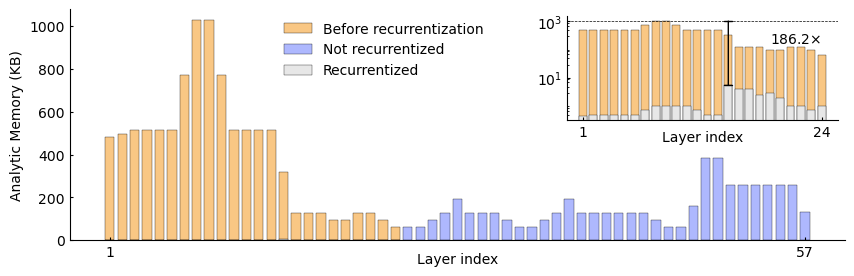

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

mem_threshold = 200

n_layers_recurrentized = len(input_processing_model_layer_memory) + len(recurrentized_level_layer_memories[0]) + len(recurrentized_level_layer_memories[1])
recurrentized_memory = input_processing_model_layer_memory + recurrentized_level_layer_memories[0] + recurrentized_level_layer_memories[1]
recurrentized_memory_in_kb = list(map(lambda m: m / 1024, recurrentized_memory))

full_model_memory = full_model_layer_memory
full_model_memory_in_kb = list(map(lambda m: m / 1024, full_model_memory))
n_layers = len(full_model_memory)

ax.bar(
    range(len(full_model_memory)),
    full_model_memory_in_kb,
    color=[colors_dict["sunset"] if l < n_layers_recurrentized else colors_dict["periwinkle"] for l in range(n_layers)],
    edgecolor="black",
    linewidth=bar_linewidth,
    width=bar_width,
)
ax.bar(
    range(n_layers_recurrentized),
    recurrentized_memory_in_kb,
    color=colors_dict["platinum"],
    edgecolor="black",
    linewidth=bar_linewidth,
    width=bar_width,
)

axins = inset_axes(ax, width="35%", height="45%", loc="upper right")


axins.bar(
    range(n_layers_recurrentized),
    full_model_memory_in_kb[:n_layers_recurrentized],
    color=[colors_dict["sunset"] if l < n_layers_recurrentized else colors_dict["periwinkle"] for l in range(n_layers)],
    edgecolor="black",
    linewidth=bar_linewidth,
    width=bar_width,
)
axins.bar(
    range(n_layers_recurrentized),
    recurrentized_memory_in_kb,
    color=colors_dict["platinum"],
    edgecolor="black",
    linewidth=bar_linewidth,
    width=bar_width,
)
axins.axhline(np.max(full_model_memory_in_kb), color="#020202", linestyle="--", linewidth=line_linewidth)

ax.set_xticks([0, n_layers - 1], ["1", f"{n_layers}"])
ax.set_xlabel("Layer index")
ax.xaxis.set_label_coords(0.5, -0.05)
ax.set_ylabel("Analytic Memory (KB)")

axins.set_xticks([0, n_layers_recurrentized - 1], ["1", f"{n_layers_recurrentized}"])
axins.set_xlabel("Layer index")
axins.xaxis.set_label_coords(0.5, -0.1)
axins.set_yscale("log")

axins.yaxis.set_minor_locator(plt.LogLocator(base=10., subs=np.array([1, 3, 5, 7, 9]) * 0.1, numticks=10))
axins.yaxis.set_minor_formatter(plt.NullFormatter())
axins.tick_params(axis="y", which="minor", length=1.5, direction="in")

axins.annotate(
    "", 
    xytext=(np.argmax(recurrentized_memory_in_kb[:n_layers_recurrentized]), np.max(full_model_memory_in_kb[:n_layers_recurrentized])), 
    xy=(np.argmax(recurrentized_memory_in_kb[:n_layers_recurrentized]), np.max(recurrentized_memory_in_kb)),
    arrowprops=dict(arrowstyle="|-|,widthA=0.3,widthB=0.3", color="#020202", linewidth=1, shrinkA=0, shrinkB=0)
)
axins.text(
    np.argmax(recurrentized_memory_in_kb[:n_layers_recurrentized]) + 4, 
    np.max(full_model_memory_in_kb) - 800,
    f"{np.max(full_model_memory_in_kb) / np.max(recurrentized_memory_in_kb):.1f}$\\times$",
    color="#020202", ha="left", va="center"
)

# Define the legend handles
exceeding_patch = mpatches.Patch(facecolor=colors_dict["sunset"], label="Before recurrentization", edgecolor="black", linewidth=bar_linewidth)
not_exceeding_patch = mpatches.Patch(facecolor=colors_dict["periwinkle"], label="Not recurrentized", edgecolor="black", linewidth=bar_linewidth)
recurrentized_patch = mpatches.Patch(facecolor=colors_dict["platinum"], label="Recurrentized", edgecolor="black", linewidth=bar_linewidth)

# Add the legend to axes[0]
ax.legend(
    handles=[exceeding_patch, not_exceeding_patch, recurrentized_patch],
    loc="upper right",  # Adjust the location as needed
    frameon=False,  # Removes the legend box
    bbox_to_anchor=(0.55, 1),
)

for ax in [ax, axins]:
    ax.tick_params(axis="both", direction="in", which="major", length=2)
    ax.spines[["top", "right"]].set_visible(False)

## Figure 11(b): analytical computation overhead (FLOPS) comparison

We only compare analytical results in this notebook as real measurements require an ESP32-S3 MCU.

### To prepare a patch-to-patch inference model

The patch-to-patch inference method do not cache any intermediate results. Therefore the input patch size would be the receptive field of one final output element with respect to the input.

In [12]:
p2p_model = recurrentization.get_patch_to_patch_model(
    no_batch_input_shape=input_shape[1:],
    model_config=example_config.model_config,
    convert_to_level=2,
    lift_to_2d=True,
    fix_batch_size=True
)

### To measure flops

FLOPs are returned from the TFLite converter tool.

We can see for each element output, it requires 1.636 M ops.

In [13]:
def tflite_model_conversion(model_to_convert):
    def dummy_rep_gen():
        if isinstance(model_to_convert.input, dict):
            random_inputs = {
                k: np.random.rand(100, *v.shape[1:]).astype(np.float32) for k, v in model_to_convert.input.items()
            }
            for x in tf.data.Dataset.from_tensor_slices(random_inputs).batch(1):
                yield x
        else:
            random_inputs = np.random.rand(100, *model_to_convert.input.shape[1:]).astype(np.float32)
            for x in tf.data.Dataset.from_tensor_slices(random_inputs).batch(1):
                yield [x]

    converter = tf.lite.TFLiteConverter.from_keras_model(model_to_convert)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = dummy_rep_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

    tflite_model = converter.convert()
    return tflite_model

In [ ]:
# this cell outputs the number of ops and the final few lines of outputs
_ = tflite_model_conversion(p2p_model)

INFO:tensorflow:Assets written to: /tmp/tmpuyfgjklu/assets


INFO:tensorflow:Assets written to: /tmp/tmpuyfgjklu/assets
/home/dongyin/miniconda3/envs/rfeye/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-01-07 10:55:47.337917: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-01-07 10:55:47.337931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-01-07 10:55:47.338238: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuyfgjklu
2025-01-07 10:55:47.340132: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-01-07 10:55:47.340144: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuyfgjklu
2025-01-07 10:55:47.344752: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimiz

In [ ]:
# similarly, we can measure #OPs of other models
_ = tflite_model_conversion(full_model)

In [ ]:
_ = tflite_model_conversion(input_processing_model)

In [ ]:
_ = tflite_model_conversion(recurrentized_levels[0])

In [ ]:
_ = tflite_model_conversion(recurrentized_levels[1])

### Visualization

The #OPs are directly documented here for simplicity.

In [1]:
# units: M Ops.
full_model_ops = 89.075

input_processing_model_ops = 0.042
level_0_ops = 0.111
level_1_ops = 0.036
remaining_model_ops = 27.349

p2p_model_ops = 1.636

In [3]:
# to achieve the same output, input processing model needs to process 1024 times (it is broken down to per-frame operation).
# level 0 and level 1 needs to process 129 times. The padding operation requires the additional 1 more time.
rec_model_total_ops = input_processing_model_ops * 1024 + (level_0_ops + level_1_ops) * 129 + remaining_model_ops

# to achieve the same output, p2p model needs to process 128 times.
p2p_model_total_ops = p2p_model_ops * 128

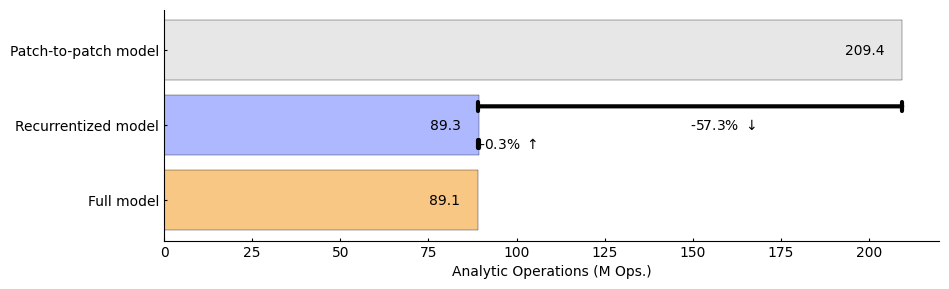

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.barh(
    ["Full model", "Recurrentized model", "Patch-to-patch model"],
    [full_model_ops, rec_model_total_ops, p2p_model_total_ops],
    color=[colors_dict["sunset"], colors_dict["periwinkle"], colors_dict["platinum"]],
    edgecolor="black",
    linewidth=bar_linewidth,
)

# add text annotation
for i, ops in enumerate([full_model_ops, rec_model_total_ops, p2p_model_total_ops]):
    ax.text(ops - 5, i, f"{ops:.1f}", va="center", ha="right")

# add arrow annotation
ax.annotate(
    "", 
    xytext=(rec_model_total_ops, 1 - 0.25), 
    xy=(full_model_ops, 1 - 0.25),
    arrowprops=dict(arrowstyle="|-|,widthA=0.3,widthB=0.3", color="#020202", linewidth=3, shrinkA=0, shrinkB=0)
)
rec_to_full_increment_in_percentage = (full_model_ops - rec_model_total_ops) / rec_model_total_ops * 100
ax.text(
    (rec_model_total_ops + full_model_ops) / 2, 1 - 0.25, f"{rec_to_full_increment_in_percentage:.1f}% $\\uparrow$", color="#020202", ha="left", va="center"
)
ax.annotate(
    "", 
    xytext=(p2p_model_total_ops, 1 + 0.25), 
    xy=(full_model_ops, 1 + 0.25),
    arrowprops=dict(arrowstyle="|-|,widthA=0.3,widthB=0.3", color="#020202", linewidth=3, shrinkA=0, shrinkB=0)
)
rec_to_p2p_decrement_in_percentage = (rec_model_total_ops - p2p_model_total_ops) / p2p_model_total_ops * 100
ax.text(
    (p2p_model_total_ops + full_model_ops) / 2, 1, f"{rec_to_p2p_decrement_in_percentage:.1f}% $\\downarrow$", color="#020202", ha="left", va="center"
)

ax.set_xlabel("Analytic Operations (M Ops.)")

ax.tick_params(axis="both", direction="in", which="major", length=2)
ax.spines[["top", "right"]].set_visible(False)